In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
pd.set_option('display.width',200)
pd.set_option('display.max_colwidth',100)

## This file helps you plot more efficiently
feel free to contact me(yl3963@columbia.edu) if you have any questions


## prepare dataset

In [2]:
twitter2 = pd.read_csv("trayvontweets/Trayvon Tweets 2013.csv",encoding = "latin1", index_col = 0)

/Users/ycr/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ycr/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
twitter2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 20 columns):
id                      1048575 non-null int64
message_id              1048575 non-null int64
user_handle             1048575 non-null object
orig_user_id            1048575 non-null int64
orig_user_handle        1048574 non-null object
topsy_type              1048575 non-null object
orig_date_posted_gmt    1048575 non-null float64
date_posted_gmt         1048575 non-null float64
message                 1046510 non-null object
orig_user_location      1048575 non-null object
coordinates             20954 non-null object
tweet_location          25439 non-null object
longitude               20954 non-null float64
latitude                20954 non-null float64
created_at_gmt          229732 non-null float64
seconds_after_event     1048575 non-null int64
FIPS                    1048575 non-null object
County                  1048569 non-null object
City                    1041990

In [4]:
data_msg_time = twitter2.loc[twitter2['message'].isnull() == False,['date_posted_gmt','message']]

In [5]:
data_msg_time = data_msg_time.sample(n = 100000,random_state=0)
data_msg_time = data_msg_time.reset_index(drop = True)

In [6]:
def date(dates):
    delta=datetime.timedelta(days=dates)
    today=datetime.datetime.strptime('1899-12-30 00:00:00','%Y-%m-%d %H:%M:%S')+delta
    return datetime.datetime.strftime(today,'%Y-%m-%d %H:%M:%S')

In [7]:
data_msg_time['date_posted_gmt'] = data_msg_time['date_posted_gmt'].apply(lambda x: date(x))

In [8]:
data_msg_time.head()

,date_posted_gmt,message
0,2013-07-14 04:14:00,Zimmerman Was Found Not Guilty Of Murder BUT Did Yall Heard The Second Part Trayvon Martin Was F...
1,2013-07-11 15:40:08,Justice for Trayvon Martin man!!!!
2,2013-07-11 01:09:12,The defense rested in the #GeorgeZimmerman trial today. Zimmerman himself never took the stand. ...
3,2013-07-21 16:25:20,Authoräó»s Heated TV Exchange After He Offers to Buy George Zimmerman a New Gun http://t.co/pvv5...
4,2013-07-15 01:38:56,Earlier: George Zimmerman Not Off the Hook (Maybe) ... FEDS Could Prosecute http://t.co/NhHz9vXcw1


###  add year month day week days_from_event columns for original dataframe

In [9]:
def add_ymdw(df):
    df['date']=pd.to_datetime(df['date_posted_gmt'])

    df['year']=df['date'].apply(lambda x: x.year)

    df['month']=df['date'].apply(lambda x: x.month)

    df['day']=df['date'].apply(lambda x: x.day)
    
    def getweek(a,b,c):
        return datetime.date(a,b,c).isocalendar()[1]
    df['week'] = df.apply(lambda x: getweek(x['year'], x['month'],x['day']), axis=1)
    
    return df

In [10]:
data_msg_time=add_ymdw(data_msg_time)

In [11]:
event_date = '20130713'
data_msg_time['days_from_event'] = data_msg_time.apply(lambda x: (x['date'] - pd.to_datetime(event_date)).days, axis=1)


### split dataset according to their year
you can get 3 dataframes finally

In [12]:
def split_year(df):
    df2012=df[df['year']==2012]
    df2013=df[df['year']==2013]
    df2014=df[df['year']==2014]
    return df2013,df2013,df2014

In [13]:
data_msg_time2012,data_msg_time2013,data_msg_time2014=split_year(data_msg_time)
data_msg_time2013.head()

,date_posted_gmt,message,date,year,month,day,week,days_from_event
0,2013-07-14 04:14:00,Zimmerman Was Found Not Guilty Of Murder BUT Did Yall Heard The Second Part Trayvon Martin Was F...,2013-07-14 04:14:00,2013,7,14,28,1
1,2013-07-11 15:40:08,Justice for Trayvon Martin man!!!!,2013-07-11 15:40:08,2013,7,11,28,-2
2,2013-07-11 01:09:12,The defense rested in the #GeorgeZimmerman trial today. Zimmerman himself never took the stand. ...,2013-07-11 01:09:12,2013,7,11,28,-2
3,2013-07-21 16:25:20,Authoräó»s Heated TV Exchange After He Offers to Buy George Zimmerman a New Gun http://t.co/pvv5...,2013-07-21 16:25:20,2013,7,21,29,8
4,2013-07-15 01:38:56,Earlier: George Zimmerman Not Off the Hook (Maybe) ... FEDS Could Prosecute http://t.co/NhHz9vXcw1,2013-07-15 01:38:56,2013,7,15,29,2


### preprocess message

In [14]:
#change all to lower case for future regex
data_msg_time2013['message'] = data_msg_time2013['message'].str.lower()

/Users/ycr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## detect emotions

### import LIWC dictionary

In [15]:
file = open("LIWC Dictionary/LIWC_dic.txt","r")

LIWC = file.readlines()
LIWC_dict = {}
for line in LIWC:
    line = line.split(',')
    category = line[0]
    words = line[1:]
    words[0] = words[0][1:]
    words[-1] = words[-1][:-2]
    LIWC_dict[category] = words

In [16]:
LIWC_dict.keys()

dict_keys(['Function', 'Pronoun', 'Ppron', 'I', 'We', 'You', 'SheHe', 'They', 'Ipron', 'Article', 'Prep', 'Auxverb', 'Adverb', 'Conj', 'Negate', 'Verb', 'Adj', 'Compare', 'Interrog', 'Number', 'Quant', 'Affect', 'Posemo', 'Negemo', 'Anx', 'Anger', 'Sad', 'Social', 'Family', 'Friend', 'Female', 'Male', 'CogProc', 'Insight', 'Cause', 'Discrep', 'Tentat', 'Certain', 'Differ', 'Percept', 'See', 'Hear', 'Feel', 'Bio', 'Body', 'Health', 'Sexual', 'Ingest', 'Drives', 'Affiliation', 'Achieve', 'Power', 'Reward', 'Risk', 'FocusPast', 'FocusPresent', 'FocusFuture', 'Relativ', 'Motion', 'Space', 'Time', 'Work', 'Leisure', 'Home', 'Money', 'Relig', 'Death', 'Informal', 'Swear', 'Netspeak', 'Assent', 'Nonflu', 'Filler', 'Stress'])

### Adjust LIWC dictionary

In [17]:
posemo = LIWC_dict['Posemo']
for i in range(len(posemo)):
    if posemo[i][-1] == '*':
        posemo[i] = r'\b' + posemo[i][:-1]
    else:
        posemo[i] = r'\b' + posemo[i] + r'\b'
posemo[0] = '\(:'
posemo[5] = ':\)'
reg_posemo = "|".join(posemo)
reg_posemo = re.compile(reg_posemo)

In [18]:
negemo = LIWC_dict['Negemo']
for i in range(len(negemo)):
    if negemo[i][-1] == '*':
        negemo[i] = r'\b' + negemo[i][:-1]
    else:
        negemo[i] = r'\b' + negemo[i] + r'\b'
negemo[0] = '\):'
negemo[5] = ':\('
reg_negemo = "|".join(negemo)
reg_negemo = re.compile(reg_negemo)

In [19]:
anx = LIWC_dict['Anx']
for i in range(len(anx)):
    if anx[i][-1] == '*':
        anx[i] = r'\b' + anx[i][:-1]
    else:
        anx[i] = r'\b' + anx[i] + r'\b'
reg_anx = "|".join(anx)
reg_anx = re.compile(reg_anx)

In [20]:
anger = LIWC_dict['Anger']
for i in range(len(anger)):
    if anger[i][-1] == '*':
        anger[i] = r'\b' + anger[i][:-1]
    else:
        anger[i] = r'\b' + anger[i] + r'\b'
reg_anger = "|".join(anger)
reg_anger = re.compile(reg_anger)

In [21]:
sad = LIWC_dict['Sad']
for i in range(len(sad)):
    if sad[i][-1] == '*':
        sad[i] = r'\b' + sad[i][:-1]
    else:
        sad[i] = r'\b' + sad[i] + r'\b'
reg_sad = "|".join(sad)
reg_sad = re.compile(reg_sad)

In [22]:
stress = LIWC_dict['Stress']
for i in range(len(stress)):
    if stress[i][-1] == '*':
        stress[i] = r'\b' + stress[i][:-1]
    else:
        stress[i] = r'\b' + stress[i] + r'\b'
reg_stress = "|".join(stress)
reg_stress = re.compile(reg_stress)

In [23]:
reg_posemo.search("humorabc")

<re.Match object; span=(0, 5), match='humor'>

In [24]:
reg_posemo.search("happyhhh")

### function to check whether the message contains the category or not

In [25]:
def check_category(s,category,dic):
    '''
    s type: string
    category type: list of string 
    '''
    if category == 'Posemo':
        if reg_posemo.search(s):
            return category
    elif category == 'Negemo':
        if reg_negemo.search(s):
            return category
    elif category == 'Anx':
        if reg_anx.search(s):
            return category
    elif category == 'Anger':
        if reg_anger.search(s):
            return category
    elif category == 'Sad':
        if reg_sad.search(s):
            return category
    elif category == 'Stress':
        if reg_stress.search(s):
            return category
    else:
        print("only valid for six category")
    return 'NA'

In [26]:
check_category('stressed','Anx',LIWC_dict)

'Anx'

In [27]:
check_category('happy!!!','Anx',LIWC_dict)

'NA'

In [28]:
check_category('afraid','Negemo',LIWC_dict)

'Negemo'

In [29]:
check_category('confu','Negemo',LIWC_dict)

'NA'

### add_tag_col
- df:  dataframe 
- cate: list of emotion category
- dic: the dictionary stores all words belong to the category
e.g. here tag='Anx' means the message of the row contains anxiety words

In [30]:
def add_tag_col(df,cate,dic):
    for category in cate:
        df[category]=df.apply(lambda x: check_category(x['message'],category,dic),axis=1)
    return df

In [31]:
data_msg_time2013.head()

,date_posted_gmt,message,date,year,month,day,week,days_from_event
0,2013-07-14 04:14:00,zimmerman was found not guilty of murder but did yall heard the second part trayvon martin was f...,2013-07-14 04:14:00,2013,7,14,28,1
1,2013-07-11 15:40:08,justice for trayvon martin man!!!!,2013-07-11 15:40:08,2013,7,11,28,-2
2,2013-07-11 01:09:12,the defense rested in the #georgezimmerman trial today. zimmerman himself never took the stand. ...,2013-07-11 01:09:12,2013,7,11,28,-2
3,2013-07-21 16:25:20,authoräó»s heated tv exchange after he offers to buy george zimmerman a new gun http://t.co/pvv5...,2013-07-21 16:25:20,2013,7,21,29,8
4,2013-07-15 01:38:56,earlier: george zimmerman not off the hook (maybe) ... feds could prosecute http://t.co/nhhz9vxcw1,2013-07-15 01:38:56,2013,7,15,29,2


In [32]:
emotions = ['Sad','Anx','Anger','Negemo','Posemo','Stress']
data_msg_time2013=add_tag_col(data_msg_time2013,emotions,LIWC_dict)  
data_msg_time2013.head()

/Users/ycr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date_posted_gmt,message,date,year,month,day,week,days_from_event,Sad,Anx,Anger,Negemo,Posemo,Stress
0,2013-07-14 04:14:00,zimmerman was found not guilty of murder but did yall heard the second part trayvon martin was f...,2013-07-14 04:14:00,2013,7,14,28,1,NA,Anx,Anger,Negemo,NA,NA
1,2013-07-11 15:40:08,justice for trayvon martin man!!!!,2013-07-11 15:40:08,2013,7,11,28,-2,NA,NA,NA,NA,NA,NA
2,2013-07-11 01:09:12,the defense rested in the #georgezimmerman trial today. zimmerman himself never took the stand. ...,2013-07-11 01:09:12,2013,7,11,28,-2,NA,NA,NA,Negemo,NA,NA
3,2013-07-21 16:25:20,authoräó»s heated tv exchange after he offers to buy george zimmerman a new gun http://t.co/pvv5...,2013-07-21 16:25:20,2013,7,21,29,8,NA,NA,NA,NA,NA,NA
4,2013-07-15 01:38:56,earlier: george zimmerman not off the hook (maybe) ... feds could prosecute http://t.co/nhhz9vxcw1,2013-07-15 01:38:56,2013,7,15,29,2,NA,NA,NA,NA,NA,NA


## Plot emotions in 2013

In [34]:
df_all_week = data_msg_time2013.groupby('week')['message'].count()
df_all_week

week
1       108
28    30438
29    31675
30     7450
31     2361
32     1303
33      855
34     1203
35      912
36      814
37     1376
38      265
39      453
40      347
41      325
42      213
43      297
44      700
45      351
46      312
47     1991
48      547
49      351
50      469
51      505
52      294
Name: message, dtype: int64

Most of the data are from week 28. So we will plot from week 28.

### plot_count_trend function
- df: the dataframe contains at least **message,week, tag** cols

- cate: the category of emotion e.g. anxiety='anx

In [35]:
def plot_count_trend_week(df,category):
    df_category_week = pd.DataFrame()
    for cate in category:
        df_cate_week=df[df[cate]==cate].groupby('week')['message'].count()    
        df_cate_week = pd.DataFrame(df_cate_week)
        df_cate_week.columns = [cate]
        df_category_week = pd.concat([df_category_week,df_cate_week],axis = 1)
    plt.figure(figsize=(20,8))
    plt.xlabel('week in 2013',size=20)
    plt.ylabel('tweet num',size=20)
    # gca stands for 'get current axis'
    ax = plt.gca()
    df_category_week.plot(kind='line',ax=ax,fontsize=20)
    return df_category_week

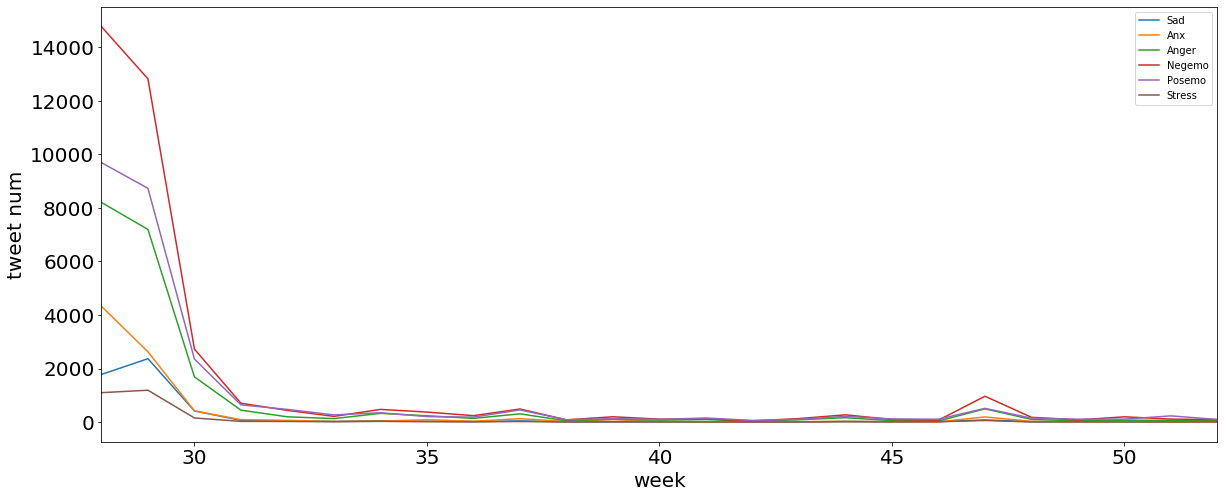

In [40]:
df_cate_week = plot_count_trend_week(data_msg_time2013.loc[data_msg_time2013['week']>=28],emotions)

### plot_fraction_trend
- df: the dataframe contains at least **message,week,tag cols**
- cate: the category of emotion e.g. anxiety='anx
- title: graph title
- xlabel: graph xlabel

In [41]:
df_all_week = pd.DataFrame(df_all_week)
df_cate_week = df_cate_week.join(df_all_week)
df_cate_week = df_cate_week.fillna(0)

In [42]:
for cate in  emotions:
    df_cate_week[cate] = df_cate_week[cate]/df_cate_week['message']*100
df_cate_week = df_cate_week.drop(columns='message')

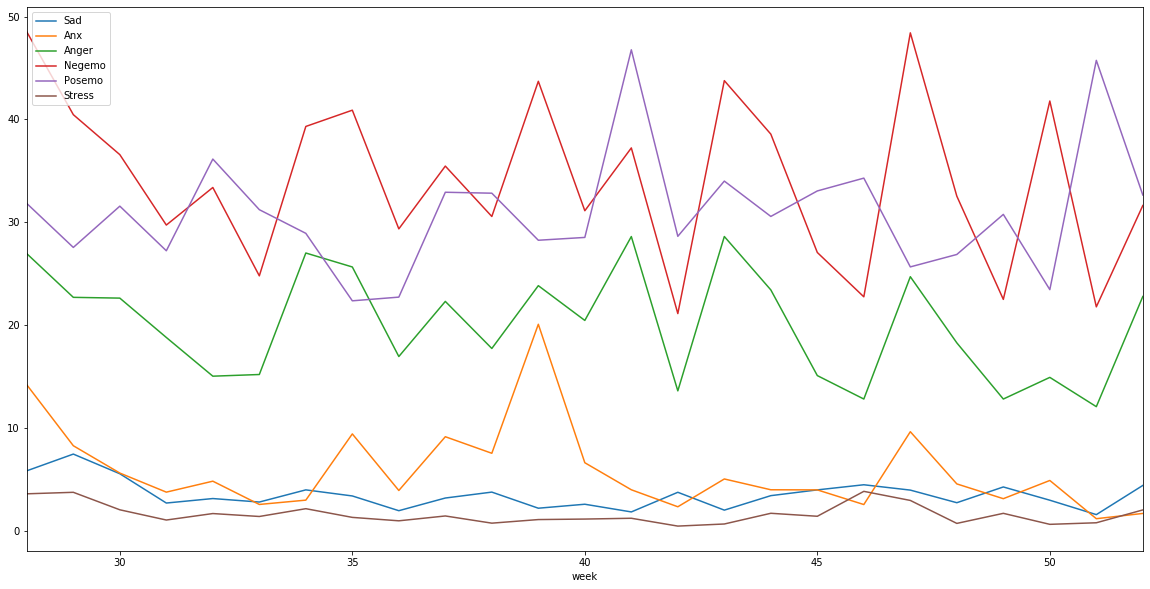

In [43]:
df_cate_week.plot(figsize=(20,10))

In [44]:
df_cate_week.corr()

,Sad,Anx,Anger,Negemo,Posemo,Stress
Sad,1.000000,0.145691,0.110674,0.190794,-0.212159,0.767372
Anx,0.145691,1.000000,0.458905,0.661434,-0.269240,0.198864
Anger,0.110674,0.458905,1.000000,0.809894,-0.029806,0.212949
Negemo,0.190794,0.661434,0.809894,1.000000,-0.267275,0.276982
Posemo,-0.212159,-0.269240,-0.029806,-0.267275,1.000000,-0.018894
Stress,0.767372,0.198864,0.212949,0.276982,-0.018894,1.000000


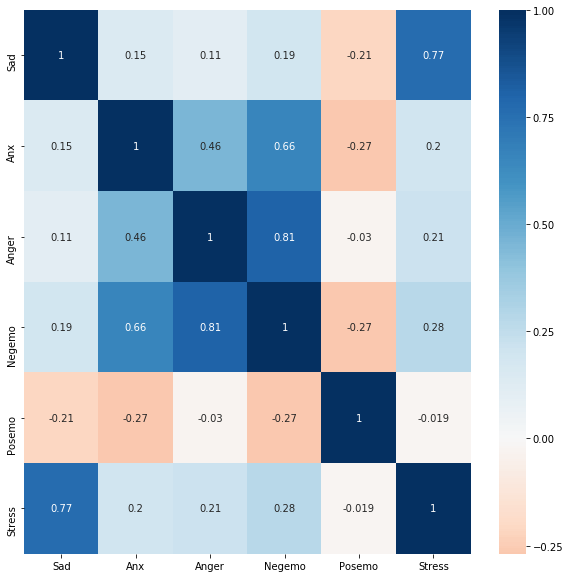

In [45]:
plt.figure(figsize=(10,10))
sns.heatmap(df_cate_week.corr(),annot=True,center=0,cmap='RdBu')

## Plot emotions after events happened 90 days

In [46]:
def plot_count_trend_days(df,category):
    df_category_week = pd.DataFrame()
    for cate in category:
        df_cate_week=df[df[cate]==cate].groupby('days_from_event')['message'].count()    
        df_cate_week = pd.DataFrame(df_cate_week)
        df_cate_week.columns = [cate]
        df_category_week = pd.concat([df_category_week,df_cate_week],axis = 1)
    plt.figure(figsize=(20,8))
    plt.xlabel('days after event',size=20)
    plt.ylabel('tweet num',size=20)
    # gca stands for 'get current axis'
    ax = plt.gca()
    df_category_week.plot(kind='line',ax=ax,fontsize=20)
    return df_category_week

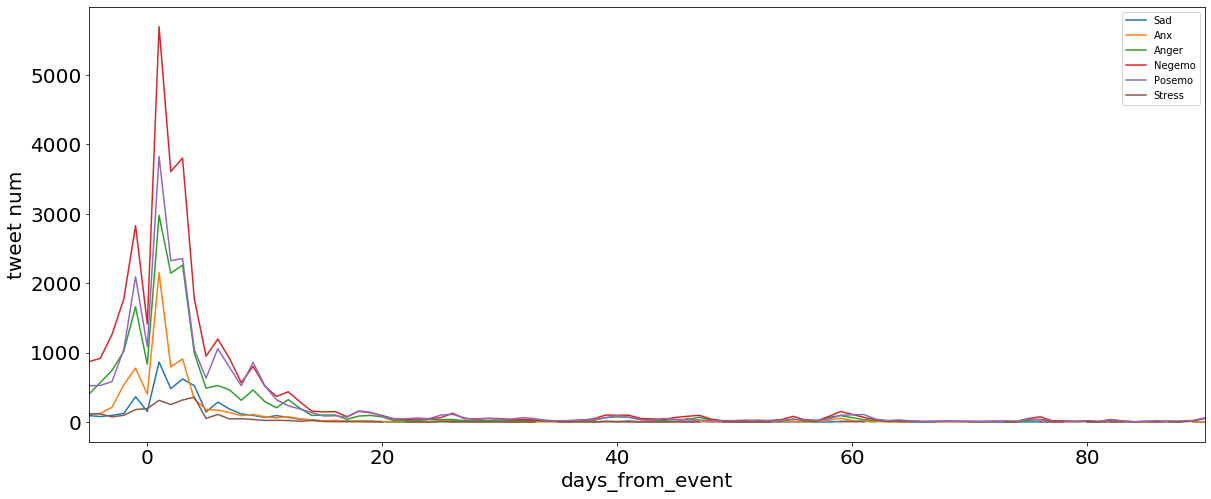

In [47]:
df_cate_days_narrow = plot_count_trend_days(data_msg_time2013.loc[(data_msg_time2013['days_from_event']<=90)],emotions)


In [48]:
df_all_days = data_msg_time2013.groupby('days_from_event')['message'].count()
df_all_days = pd.DataFrame(df_all_days)
df_cate_days_narrow = df_cate_days_narrow.join(df_all_days)
df_cate_days_narrow = df_cate_days_narrow.fillna(0)

In [49]:
for cate in  emotions:
    df_cate_days_narrow[cate] = df_cate_days_narrow[cate]/df_cate_days_narrow['message']*100
df_cate_days_narrow = df_cate_days_narrow.drop(columns='message')

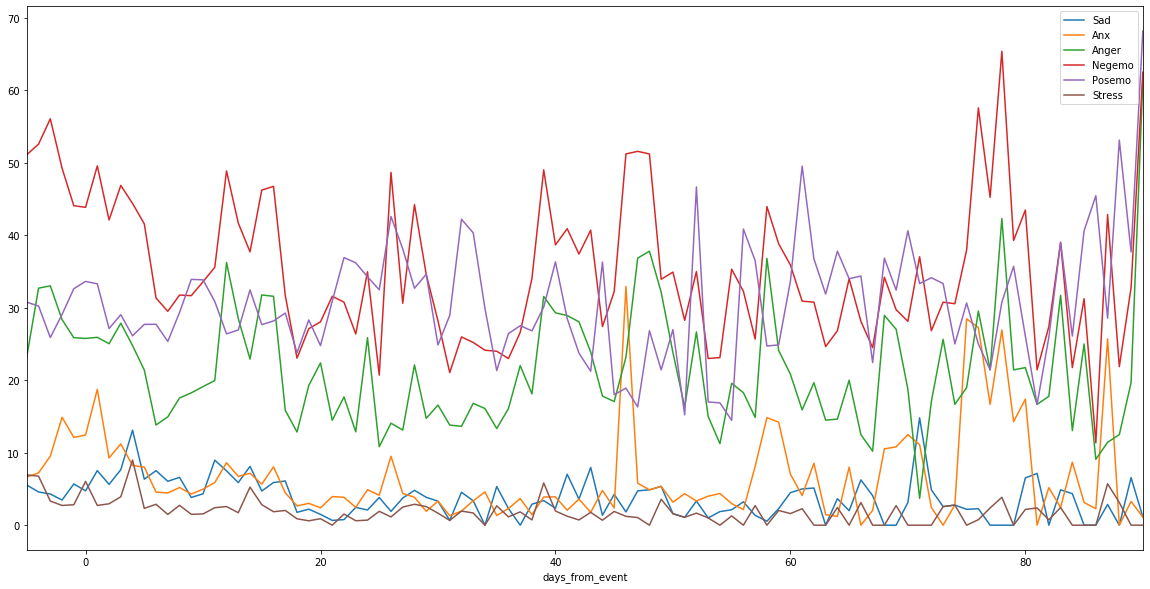

In [50]:
df_cate_days_narrow.plot(figsize=(20,10))

In [51]:
df_cate_days_narrow.corr()

,Sad,Anx,Anger,Negemo,Posemo,Stress
Sad,1.000000,-0.034176,-0.018543,0.218068,-0.126237,0.395262
Anx,-0.034176,1.000000,0.217810,0.550346,-0.151057,0.126961
Anger,-0.018543,0.217810,1.000000,0.762554,0.102449,0.171533
Negemo,0.218068,0.550346,0.762554,1.000000,-0.013935,0.370044
Posemo,-0.126237,-0.151057,0.102449,-0.013935,1.000000,-0.076676
Stress,0.395262,0.126961,0.171533,0.370044,-0.076676,1.000000


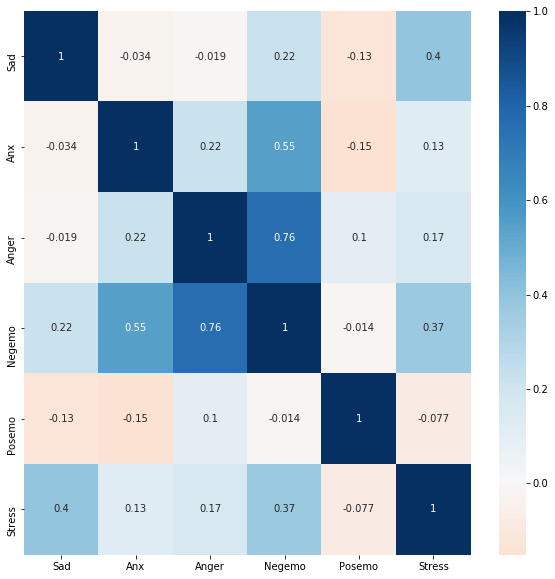

In [52]:
plt.figure(figsize=(10,10))
sns.heatmap(df_cate_days_narrow.corr(),annot=True,center=0,cmap='RdBu')

**Only look at Posemo&Negemo**

In [53]:
df_cate_days_narrow = df_cate_days_narrow[['Posemo','Negemo']]

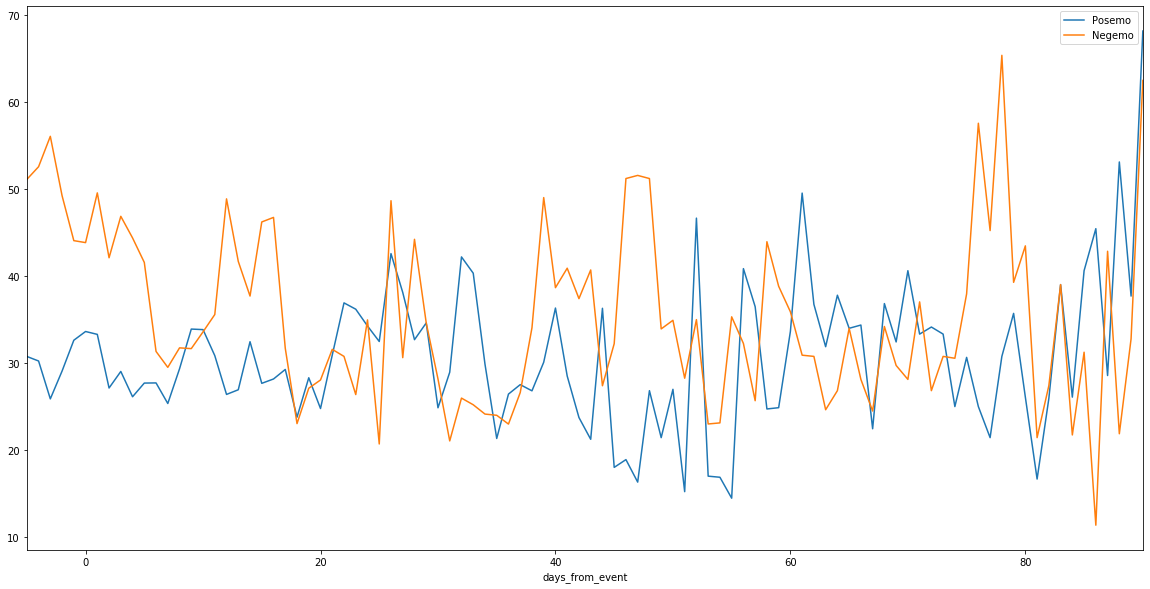

In [54]:
df_cate_days_narrow.plot(figsize=(20,10))

In [55]:
df_cate_days_narrow.corr()

,Posemo,Negemo
Posemo,1.000000,-0.013935
Negemo,-0.013935,1.000000
